In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay as plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
true_data = pd.read_csv('/content/drive/MyDrive/CS263/True.csv')
fake_data = pd.read_csv('/content/drive/MyDrive/CS263/Fake.csv')
true_label = np.ones((len(true_data)),) * 0
fake_label = np.ones((len(fake_data)),) * 1
labels = np.concatenate((true_label, fake_label), axis=None)
labels = torch.from_numpy(labels)
print(true_data.shape, true_label.shape, labels.shape)
true_data.head()

(21417, 4) (21417,) torch.Size([44898])


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
data = pd.concat([true_data, fake_data])
data.reset_index(drop=True, inplace=True)
print(data.shape)
data.head()

(44898, 4)


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Text(0, 0.5, 'Number of texts')

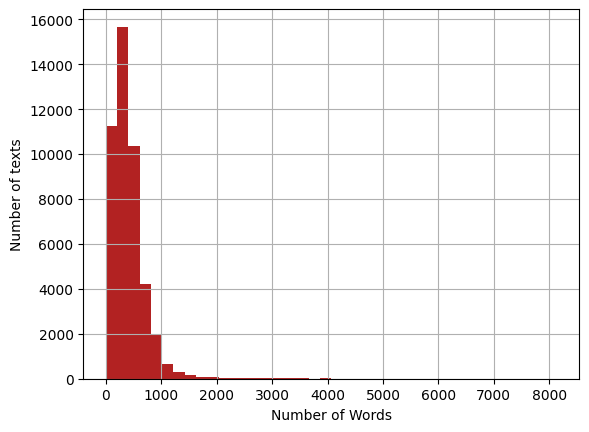

In [6]:
seq_len = [len(data['text'][i].split()) for i in range(len(data))]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

# **Word Embedding GloVe50d**

In [7]:
from tqdm import tqdm

def load_glove_model(file):
    print("Loading Glove Model")
    f = open(file,'r')
    glove_model = {}
    for line in tqdm(f):
        split_line = line.split()
        word = split_line[0]
        embedding = np.array([float(val) for val in split_line[1:]])
        glove_model[word] = embedding
    print("Done.",len(glove_model)," words loaded!")
    return glove_model

glove_model = load_glove_model('/content/drive/MyDrive/CS263/glove.6B.50d.txt')

Loading Glove Model


400000it [00:10, 39709.47it/s]

Done. 400000  words loaded!


In [8]:
def embed_sentence(sentence):
    words = sentence.split()  # Tokenizing
    vectors = [glove_model[word] for word in words if word in glove_model]
    return vectors if vectors else [np.zeros(50)]

data['embedded_text'] = data['text'].apply(embed_sentence)

In [9]:
data.head()

,title,text,subject,date,embedded_text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017","[[-0.16768, 1.2151, 0.49515, 0.26836, -0.4585,..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017","[[-0.16768, 1.2151, 0.49515, 0.26836, -0.4585,..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017","[[-0.16768, 1.2151, 0.49515, 0.26836, -0.4585,..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017","[[-0.16768, 1.2151, 0.49515, 0.26836, -0.4585,..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017","[[-0.16768, 1.2151, 0.49515, 0.26836, -0.4585,..."


In [10]:
def pad_or_truncate_vectors(vectors, maxlen):
    if len(vectors) > maxlen:

        vectors = vectors[:maxlen]
    elif len(vectors) < maxlen:
        padding = np.zeros((maxlen - len(vectors), vectors[0].shape[0]))
        vectors = np.concatenate([vectors, padding])
    return vectors

max_len = 500

data['embedded_text'] = data['embedded_text'].apply(lambda x: pad_or_truncate_vectors(x, max_len))

In [11]:
from torch.utils.data import Dataset, DataLoader, random_split

class MyDataset(Dataset):
    def __init__(self, dataframe, labels):
        self.dataframe = dataframe
        self.labels = labels

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        feature = torch.tensor(self.dataframe.iloc[idx]['embedded_text'], dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return feature, label

dataset = MyDataset(data, labels)
train_len = int(len(dataset) * 0.8)
test_len = len(dataset) - train_len

train_dataset, test_dataset = random_split(dataset, [train_len, test_len])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
len(train_dataloader)

1123

In [12]:
for i, (batch_features, batch_labels) in enumerate(train_dataloader):
  print(i, batch_features.shape, batch_labels.shape)
  break

0 torch.Size([32, 1, 500, 50]) torch.Size([32])


<ipython-input-10-90f4193925e1>:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  feature = torch.tensor(self.dataframe.iloc[idx]['embedded_text'], dtype=torch.float32).unsqueeze(0)
<ipython-input-10-90f4193925e1>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[idx], dtype=torch.long)


In [13]:
for i, data in train_dataloader:
  print(i.shape, data)
  break

torch.Size([32, 1, 500, 50]) tensor([1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 0, 1])


<ipython-input-10-90f4193925e1>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[idx], dtype=torch.long)


In [14]:
import torch
from torch import nn
from torch.optim import Adam

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.fc1 = nn.Linear(64*125*12, 128)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(128,2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        return x

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize the model, loss function and optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 5

for epoch in tqdm(range(epochs)):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_dataloader)}")

  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-10-90f4193925e1>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[idx], dtype=torch.long)
100%|██████████| 5/5 [04:30<00:00, 54.16s/it]Epoch 5, Loss: 0.3243640801509001225


In [17]:
torch.save(model.state_dict(), '/content/drive/MyDrive/CS263/model_GloVe50d_text.pth')

In [115]:
model_path = '/content/drive/MyDrive/CS263/model_GloVe50d_text.pth'
model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [19]:
import torch
import torch.nn.functional as F
from sklearn.metrics import precision_score, accuracy_score, f1_score


correct = 0
total = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data[0].to(device), data[1].to(device).long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

accuracy = 100 * correct / total
precision = precision_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f'Accuracy: {accuracy:.5f}%')
print(f'Precision: {precision:.5f}')
print(f'F1 Score: {f1:.5f}')

<ipython-input-10-90f4193925e1>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[idx], dtype=torch.long)
Accuracy: 89.87751%
Precision: 0.88757
F1 Score: 0.89313
